# **Questions 1, 2**

In [2]:
# Importing Required Packages

import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz
from scipy.linalg import solve_toeplitz
from scipy.signal import find_peaks
import librosa

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  after removing the cwd from sys.path.


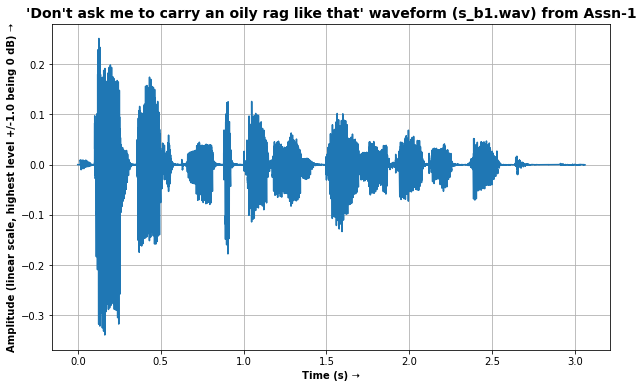

In [3]:
# Reading sentence (b) waveform s_b1.wav from Assignment-1 for the first 4 Questions
# and plotting it for a visual understanding of the waveform

samplerate, data = wavfile.read('s_b1.wav')
plt.figure(figsize=(10,6))
data_x_axis = np.arange(len(data))/samplerate

plt.plot(data_x_axis, data)
plt.grid(True)
plt.title("'Don't ask me to carry an oily rag like that' waveform (s_b1.wav) from Assn-1", fontweight = 'bold', fontsize = 14)
plt.xlabel("Time (s) \u279d", fontweight = 'bold')
plt.ylabel("Amplitude (linear scale, highest level +/-1.0 being 0 dB) \u279d", fontweight = 'bold')
plt.show()

In [4]:
# The order of the Linear Predictive Coefficients filter 

p = 18

# Calculating window size and shift size in terms of samples
# from window duration = 25 ms and shift duration = 10 ms
window_duration = 0.025
window_size = int(samplerate*window_duration)
shift_duration = 0.01
shift_size = int(samplerate*shift_duration)

In [5]:
# Function to calculate the least power of 2 greater than given length
# in order to calculate DFT

def LengthDFT(arr):
    i=0
    while True:
        if 2**i >= len(arr):
            break
        i+=1
    
    return 2**i


# Function to calculate autocorrelation value for a certain k : R_n(k)

def autocorrelation(arr, k):
    if k == 0:
        return np.sum(arr*arr)
    return np.sum(arr[:-k]*arr[k:])

In [7]:
# Selecting a random piece in the s_b1.wav waveform to plot the LP spectrum
i=10000
piece = data[i:i+window_size]
window = np.hamming(window_size)
windowed_piece = piece*window

N = LengthDFT(windowed_piece)

# Zero padding the windowed piece for the FFT algorithm to calculate DFT
windowed_piece = np.concatenate((windowed_piece, np.zeros(N-len(windowed_piece))))

# Calculating DFT of the windowed piece
dft = np.fft.fft(windowed_piece)


# Calculating LPC coefficients using librosa
ak = librosa.lpc(piece, p)

# Zero padding the LPC filter before taking DFT
xn = np.concatenate((ak, np.zeros(N-p-1)))
# Calculating the LP spectrum as H[k] = 1/H'[k]
xn_dft = 1/np.fft.fft(xn)

# Normalising by the gain factor to remove the gap between original DFT and LP Spectrum
gain = np.sqrt(np.sum(piece*piece)/window_size)
xn_dft = xn_dft*gain

"""r = [autocorrelation(piece, k) for k in range(p)]
print(r)
print(autocorrelation(piece,0), autocorrelation(piece,1), autocorrelation(piece,2))
rhs = [autocorrelation(piece, k) for k in range(1, p+1)]
a_k = solve_toeplitz((r, r), rhs)

x_n = np.concatenate(([1], a_k))
print(x_n)

x_n = np.concatenate((x_n, np.zeros(N-p-1)))
x_n_dft = 1/np.fft.fft(x_n)

print(len(piece), len(x_n))"""

'r = [autocorrelation(piece, k) for k in range(p)]\nprint(r)\nprint(autocorrelation(piece,0), autocorrelation(piece,1), autocorrelation(piece,2))\nrhs = [autocorrelation(piece, k) for k in range(1, p+1)]\na_k = solve_toeplitz((r, r), rhs)\n\nx_n = np.concatenate(([1], a_k))\nprint(x_n)\n\nx_n = np.concatenate((x_n, np.zeros(N-p-1)))\nx_n_dft = 1/np.fft.fft(x_n)\n\nprint(len(piece), len(x_n))'

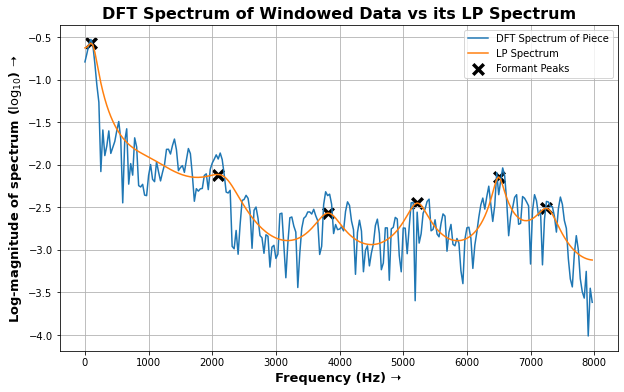

In [8]:
# Calculating the frequency axis for the spectrum in Hz from samplerate
freq_axis = np.fft.fftfreq(N, d = 1/samplerate)

# Calculating the log magnitude spectra
log_magnitude_dft = np.log10(np.abs(dft))
log_magnitude_lps = np.log10(np.abs(xn_dft))

# Plotting both spectra
plt.figure(figsize = (10,6))
plot_end = int(len(dft)/2)
plt.plot(freq_axis[:plot_end], log_magnitude_dft[:plot_end], label='DFT Spectrum of Piece')
plt.plot(freq_axis[:plot_end], log_magnitude_lps[:plot_end], label ='LP Spectrum')

# Finding formants for this window to indicate on the plot
peaks, _ = find_peaks(log_magnitude_lps)
required_formants = peaks[peaks<plot_end]

plt.scatter(freq_axis[required_formants], log_magnitude_lps[required_formants], 
            label = 'Formant Peaks', s = 6, marker = 'x', color = 'black', linewidth = 15)

plt.legend()
plt.grid(True)
plt.title("DFT Spectrum of Windowed Data vs its LP Spectrum", fontweight = 'bold', fontsize = 16)
plt.xlabel("Frequency (Hz) \u279d", fontweight = 'bold', fontsize = 13)
plt.ylabel("Log-magnitude of spectrum ($\log_{10}$) \u279d", fontweight = 'bold', fontsize = 13)
plt.show()

In [9]:
# Initialising lists contain the time-series of formant frequencies for f1, f2, f3
f1, f2, f3 = [], [], []
window = np.hamming(window_size)

# Doing the above process over all windows of the waveform to obtain formant contours
for i in range(0, len(data)-window_size+1, shift_size):
    piece = data[i:i+window_size]
    N = LengthDFT(piece)

    ak = librosa.lpc(piece, p)
    xn = np.concatenate((ak, np.zeros(N-p-1)))
    xn_dft = 1/np.fft.fft(xn)

    gain = np.sqrt(np.sum(piece*piece)/window_size)
    xn_dft = xn_dft*gain
    log_magnitude_lps = np.log10(np.abs(xn_dft))

    peaks, _ = find_peaks(log_magnitude_lps)
    formants = freq_axis[peaks]
    f1.append(formants[0])
    f2.append(formants[1])
    f3.append(formants[2])

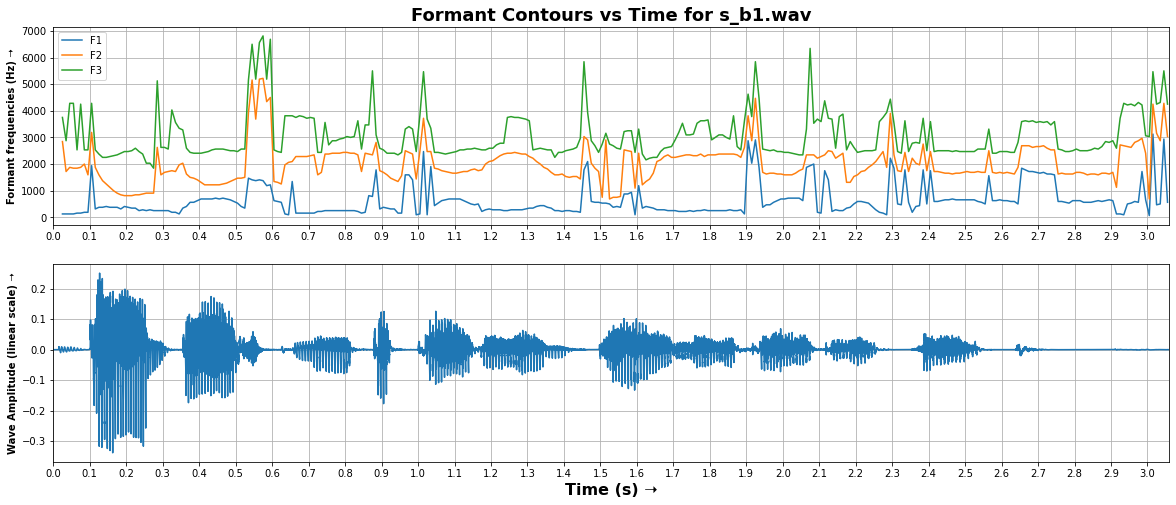

In [80]:
# Plotting formant contours

fig, ax = plt.subplots(2, 1, figsize=(20,8))
ax[0].grid(True)
x_axis = window_size/samplerate + np.arange(len(f1))*shift_size/samplerate
ax[0].plot(x_axis, f1, label = 'F1')
ax[0].plot(x_axis, f2, label = 'F2')
ax[0].plot(x_axis, f3, label = 'F3')
ax[0].set_xticks(np.arange(0,3.1,0.1))
ax[0].set_xlim(0, data_x_axis[-1])
ax[0].set_title("Formant Contours vs Time for s_b1.wav", fontweight = 'bold', fontsize = 18)
ax[0].set_ylabel("Formant frequencies (Hz) \u279d", fontweight = 'bold')
ax[0].legend()

ax[1].plot(data_x_axis, data)
ax[1].grid(True)
ax[1].set_xticks(np.arange(0,3.1,0.1))
ax[1].set_xlim(0, data_x_axis[-1])
ax[1].set_ylabel("Wave Amplitude (linear scale) \u279d", fontweight = 'bold')
ax[1].set_xlabel("Time (s) \u279d", fontweight = 'bold', fontsize = 16)
plt.show()

# **Question 3**

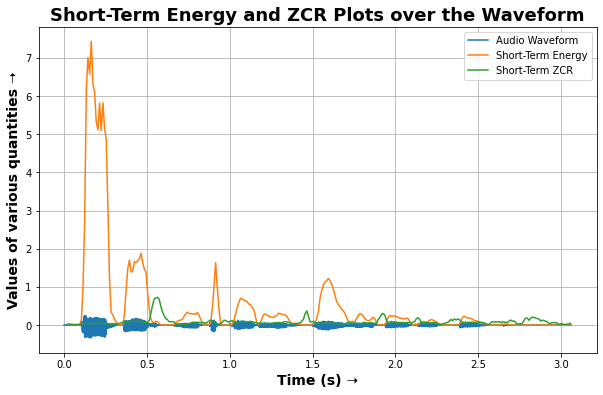

In [11]:
# Initialising array to hold the x-axis values (time) for the short-term energy
# and short-term ZCR plot
e_zcr_x_axis = []

# Arrays to hold the values of short-term energy and ZCR
st_energies, st_zcrs = [], []

# Iterating through windows, calculating and storing short-term energy and ZCR
# Also storing time values for the x-axis
for i in range(window_size,len(data), shift_size):
    piece = data[(i-window_size):i]
    e_zcr_x_axis.append(i/samplerate)
    energy = np.sum(piece**2)
    zcr = (np.sum(piece[:-1]*piece[1:] < 0) + np.sum(piece[:-1]*piece[1:] == 0)/2)/window_size
    st_energies.append(energy)
    st_zcrs.append(zcr)

# Plotting the short-term energy and ZCR curves over the waveform
e_zcr_x_axis = np.array(e_zcr_x_axis)
plt.figure(figsize=(10,6))
plt.plot(data_x_axis, data, label = 'Audio Waveform')
plt.plot(e_zcr_x_axis, st_energies, label = "Short-Term Energy")
plt.plot(e_zcr_x_axis, st_zcrs, label = "Short-Term ZCR")
plt.title("Short-Term Energy and ZCR Plots over the Waveform", fontweight = 'bold', fontsize = 18)
plt.xlabel("Time (s) \u279d", fontweight = 'bold', fontsize = 14)
plt.ylabel("Values of various quantities \u279d", fontweight = 'bold', fontsize = 14)
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Calculating the thresholds for short-term energy and ZCR, based on the paper titled
# "An Algorithm for Determing the Endpoints of Isolated Utterances" by Rabiner and Sambur, 1976.

silence_energies = st_energies[-10:]
silence_zcrs =  st_zcrs[-10:]       # Upon plotting, I saw that this range of indices was well-representative of silence

zcr_thres = min(25/160, np.mean(st_zcrs) + 2*np.std(st_zcrs))
imx = max(st_energies)
imn = np.mean(silence_energies)
i1 = 0.03*(imx-imn) + imn
i2 = 4*imn
e_thres = min(i1, i2)

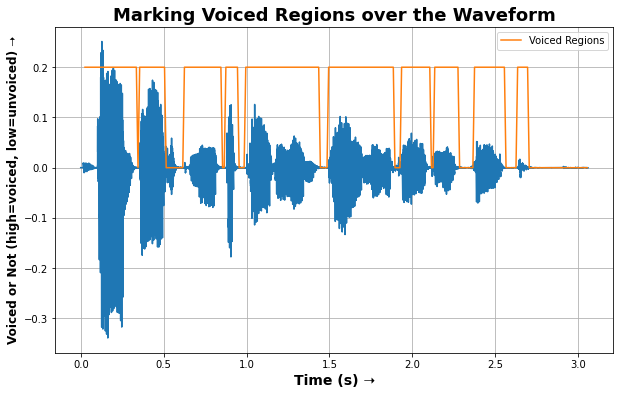

In [13]:
# Plotting a marker for voiced regions as detected by the VAD

# Evaluating high-energy windows
high_energy = np.array(st_energies) > e_thres
# Evaluating low-ZCR windows
low_zcr = np.array(st_zcrs) < zcr_thres

# Using the ensemble of both thresholds (logical 'and' of both conditions)
# to identify voiced regionds
voiced = (high_energy & low_zcr) * 0.2      # 0.2 is a factor to make the marker height 
                                            # comparable to waveform for visibility

plot_voiced = np.concatenate((voiced[1:], [0]))  # Each "voiced or not" value represents the window before.
                                            # Therefore to get a better plot of the marker, we shift the
                                            # "voiced or not" values to the left by one window.

# Plotting the voiced region marker over the waveform

plt.figure(figsize=(10,6))
plt.plot(data_x_axis, data)
plt.plot(e_zcr_x_axis, plot_voiced, label="Voiced Regions")
plt.grid(True)
plt.legend()
plt.title("Marking Voiced Regions over the Waveform", fontweight = 'bold', fontsize = 18)
plt.xlabel("Time (s) \u279d", fontweight = 'bold', fontsize = 14)
plt.ylabel("Voiced or Not (high=voiced, low=unvoiced) \u279d", fontweight = 'bold', fontsize = 12)
plt.show()

# **Question 4**

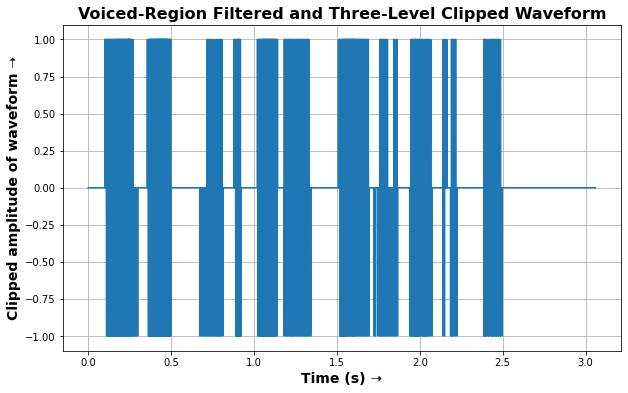

In [17]:
# Identifying the starts and ends of unvoiced regions (in terms of samples)
# using the above voiced/unvoiced info

# Since "voiced" gives info about the window BEFORE, it is used to select window ENDS
unvoiced_window_ends = e_zcr_x_axis[voiced==0]       
unvoiced_window_starts = unvoiced_window_ends - 0.025

# Creating tuples representing spans of unvoiced regions (in terms of samples)
unvoiced_spans = zip(unvoiced_window_starts, unvoiced_window_ends)

# Creating a VAD mask to mask out the unvoiced regions in the waveform
vad_mask = np.ones(len(data))

for span in unvoiced_spans:
    start_ind = int(span[0]*samplerate)
    end_ind = int(span[1]*samplerate)
    vad_mask[start_ind:end_ind] = 0 

vad_mask[-400:] = 0     # Since the last window of 400 samples is not analysed, they are defaulted to unvoiced

voiced_data = data*vad_mask     # Obtaining the voiced part of waveform alone, by masking

# USING THREE-LEVEL CLIPPING FOR SMOOTHING THE SHORT-TERM AUTOCORRELATION FUNCTION
# TO OBTAIN PERIOD MORE EASILY, FOR PITCH CALCULATION

# Calculating threshold for three-level clipping
max_1st_third = max(voiced_data[:int(len(voiced_data)/3)])
max_last_third = max(voiced_data[int(2*len(voiced_data)/3):])
clip_thres = 0.6*min(max_1st_third, max_last_third)

# All positive values > threshold given value 1
positive_level = voiced_data > clip_thres
# All negative values > threshold given value -1 by subtracting from previous array
negative_level = voiced_data < -clip_thres

# The values with absolute value < threshold automatically take the value 0 when this is done
three_lev_data = positive_level.astype(int) - negative_level.astype(int)

# Plotting the voiced-region filtered, three-level clipped waveform
plt.figure(figsize=(10,6))
plt.plot(data_x_axis, three_lev_data)
plt.grid(True)
plt.title("Voiced-Region Filtered and Three-Level Clipped Waveform", fontweight = 'bold', fontsize = 16)
plt.xlabel("Time (s) \u279d", fontweight = 'bold', fontsize = 14)
plt.ylabel("Clipped amplitude of waveform \u279d", fontweight = 'bold', fontsize = 14)
plt.show()

In [34]:
# Calculating the pitch periods (in samples) for all windows of the waveform,
# using short-term autocorrelation

pitch_period_samples = []       # Array to store pitch periods

for i in range(0, len(three_lev_data)-window_size+1, shift_size):
    three_lev_piece = three_lev_data[i:i+window_size]
    auto_corr = [autocorrelation(three_lev_piece, k) for k in range(len(three_lev_piece))]

    # Normalize autocorrelation only if it is not entirely zero for the current window
    if(max(auto_corr) > 0):
        auto_corr = auto_corr/max(auto_corr)

    # Initialising the local maximum of the autocorrelation function as NaN,
    # so that it doesn't get plotted in the final plot if there is no peak for a given window
    # (avoiding a messy plot)
    local_maximum = float('nan')

    # Using scipy.signal.find_peaks to find the peaks of the ST autcorrelation
    # Setting the "prominence" of the peak to a suitable value so that the pitch peaks are well-found 
    peaks, _ = find_peaks(auto_corr, prominence=0.4)

    # Selecting the first peak of the autocorrelation as the pitch period in terms of samples
    if len(peaks) > 0:
        local_maximum = peaks[0]

    # If the current window is mostly unvoiced, then we reset the pitch_period to NaN
    # as the pitch calculation can be inaccurate, so we avoid plotting the point
    if np.count_nonzero(vad_mask[i:i+window_size]) < 0.5*window_size:
        local_maximum = float('nan')

    pitch_period_samples.append(local_maximum)

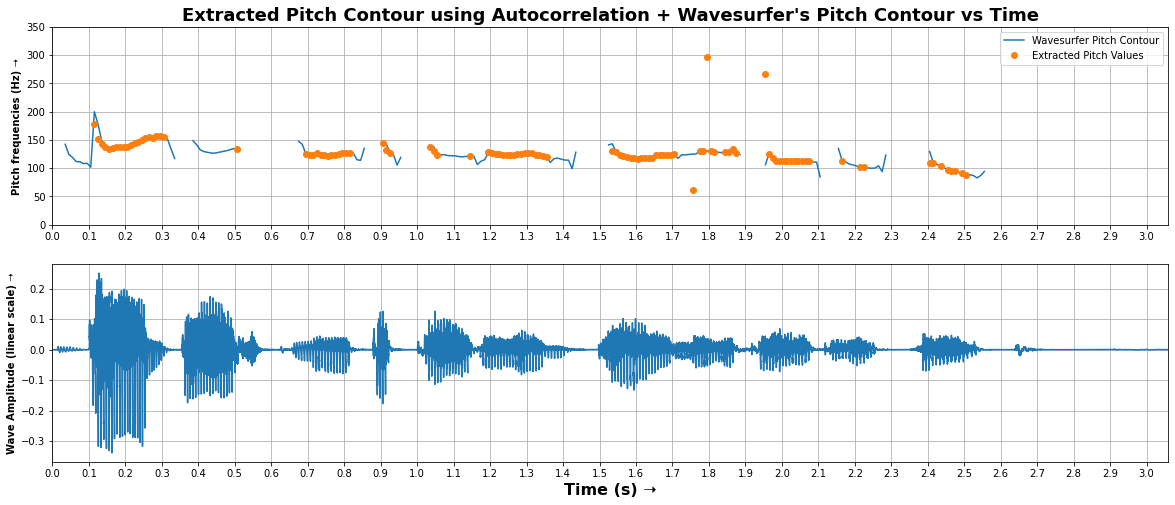

In [78]:
# Getting the pitch contour data from Wavesurfer in order to compare with our extraction of pitches
freqs = []
with open ('s_b1.f0', 'r') as f:
    while True:
        line = f.readline()
        if not line:
            break
        freqs.append(line.split()[0])
    freqs = np.array(freqs).astype(float)

# Selecting only the non-zero pitch frequencies, setting others as NaN to avoid a messy plot
pitches = np.array([freq if freq > 0 else float('nan') for freq in freqs])

# Calculating the extracted pitches using the pitch periods calculated above
# Once again, setting NaN where required
extracted_pitches = np.array([samplerate/pitch_period if pitch_period != float('nan') else float ('nan') 
                              for pitch_period in pitch_period_samples])

pitch_x_axis = (window_size/samplerate) + np.arange(len(pitches))*shift_size/samplerate
ex_pitch_x_axis = (window_size/samplerate) + np.arange(len(extracted_pitches))*shift_size/samplerate

# Plotting the extracted pitches and Wavesurfer's pitch contour for comparison

fig, ax = plt.subplots(2, 1, figsize=(20,8))
ax[0].grid(True)
ax[0].plot(pitch_x_axis, pitches, label = "Wavesurfer Pitch Contour")
ax[0].plot(ex_pitch_x_axis, extracted_pitches, 'o', label = "Extracted Pitch Values")
ax[0].set_xticks(np.arange(0,3.1,0.1))
ax[0].set_xlim(0, data_x_axis[-1])
ax[0].set_ylim(0,350)
ax[0].set_title("Extracted Pitch Contour using Autocorrelation + Wavesurfer's Pitch Contour vs Time", fontweight = 'bold', fontsize = 18)
ax[0].set_ylabel("Pitch frequencies (Hz) \u279d", fontweight = 'bold')
ax[0].legend()

ax[1].plot(data_x_axis, data)
ax[1].grid(True)
ax[1].set_xticks(np.arange(0,3.1,0.1))
ax[1].set_xlim(0, data_x_axis[-1])
ax[1].set_ylabel("Wave Amplitude (linear scale) \u279d", fontweight = 'bold')
ax[1].set_xlabel("Time (s) \u279d", fontweight = 'bold', fontsize = 16)

plt.show()

# **Question 5**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  """


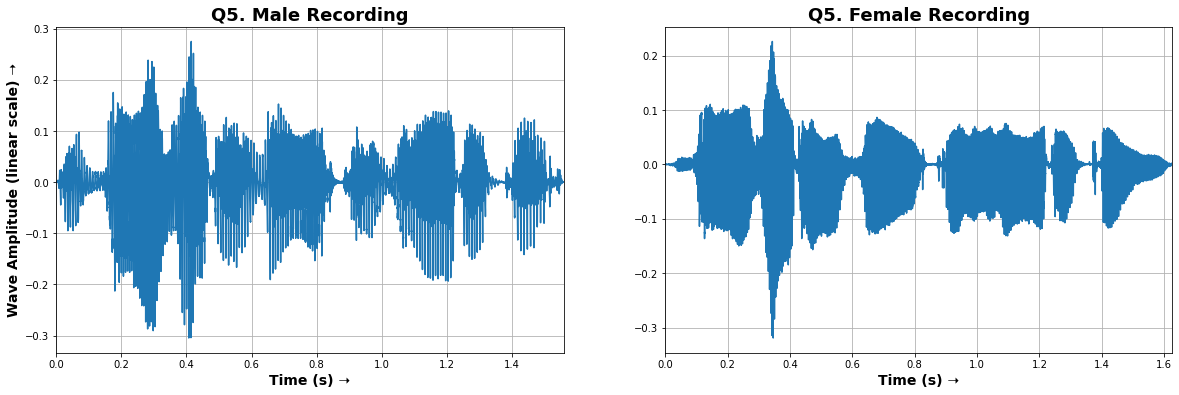

In [51]:
# Reading the male and female recordings of the sentence
# "We were away a year ago."

samplerate_male, data_male = wavfile.read('q5_male.wav')
samplerate_female, data_female = wavfile.read('q5_female.wav')

# Plotting the waveforms

data_male_x_axis = np.arange(len(data_male))/samplerate_male
data_female_x_axis = np.arange(len(data_female))/samplerate_female

fig, axes = plt.subplots(1,2,figsize=(20,6))
axes[0].plot(data_male_x_axis, data_male)
axes[0].set_xlim(0, data_male_x_axis[-1])
axes[0].grid(True)
axes[0].set_title("Q5. Male Recording", fontweight = 'bold', fontsize = 18)
axes[0].set_xlabel("Time (s) \u279d", fontweight = 'bold', fontsize = 14)
axes[0].set_ylabel("Wave Amplitude (linear scale) \u279d", fontweight = 'bold', fontsize = 14)

axes[1].plot(data_female_x_axis, data_female)
axes[1].set_xlim(0, data_female_x_axis[-1])
axes[1].grid(True)
axes[1].set_title("Q5. Female Recording", fontweight = 'bold', fontsize = 18)
axes[1].set_xlabel("Time (s) \u279d", fontweight = 'bold', fontsize = 14)

plt.show()

In [52]:
# CALCULATION OF SPECTROGRAM

window = np.hamming(window_size)

no_of_windows_male = int((len(data_male)-window_size+1)/shift_size)+1
no_of_windows_female = int((len(data_female)-window_size+1)/shift_size)+1

# Initialising 2D arrays to store the spectrograms of both recordings
spectrogram_male = np.zeros((int(N/2), no_of_windows_male))
spectrogram_female = np.zeros((int(N/2), no_of_windows_female))


# Calcualting male spectrogram

for i in range(0, len(data_male)-window_size+1, shift_size):
    piece = data_male[i:i+window_size]

    window = np.hamming(window_size)
    windowed_piece = piece*window

    # Calculating the short-term DFT of the current window
    N = LengthDFT(windowed_piece)

    windowed_piece = np.concatenate((windowed_piece, np.zeros(N-len(windowed_piece))))

    dft = np.fft.fft(windowed_piece)

    # Setting the short-term log-magnitude DFT equal to the corresponding column in the spectrogram 
    # (corresponding to the current time-window)
    spectrogram_male[:,int(i/shift_size)] = np.log10(np.abs(dft[:int(N/2)]))

########################

# Calculating female spectrogram similarly

for i in range(0, len(data_female)-window_size+1, shift_size):
    piece = data_female[i:i+window_size]

    window = np.hamming(window_size)
    windowed_piece = piece*window

    N = LengthDFT(windowed_piece)

    windowed_piece = np.concatenate((windowed_piece, np.zeros(N-len(windowed_piece))))

    dft = np.fft.fft(windowed_piece)
    spectrogram_female[:,int(i/shift_size)] = np.log10(np.abs(dft[:int(N/2)]))

In [75]:
# Calculating formant contours for male recording

f1_male, f2_male, f3_male = [], [], []
freq_axis_male = np.fft.fftfreq(N, d = 1/samplerate_male)

for i in range(0, len(data_male)-window_size+1, shift_size):
    piece = data_male[i:i+window_size]
    N = LengthDFT(piece)

    ak = librosa.lpc(piece, p)
    xn = np.concatenate((ak, np.zeros(N-p-1)))
    xn_dft = 1/np.fft.fft(xn)
    
    gain = np.sqrt(np.sum(piece*piece)/window_size)
    xn_dft = xn_dft*gain
    log_magnitude_lps = np.log10(np.abs(xn_dft))

    peaks, _ = find_peaks(log_magnitude_lps, prominence = 0)
    peaks = peaks[:int(len(peaks)/2)]
    formants = freq_axis_male[peaks]

    if np.count_nonzero(piece) >  0.3*len(piece): 

        if len(peaks)>0:
            f1_male.append(formants[0])
        elif len(f1_male) > 0:
            f1_male.append(f1_male[-1])
        else:
            f1_male.append(0)
        if len(peaks)>1:
            f2_male.append(formants[1])
        elif len(f2_male) > 0:
            f2_male.append(f2_male[-1])
        else:
            f2_male.append(0)
        if len(peaks)>2:
            f3_male.append(formants[2])
        elif len(f3_male) > 0:
            f3_male.append(f3_male[-1])
        else:
            f3_male.append(0)
    else:
        if len(f1_male) > 0:
            f1_male.append(f1_male[-1])
        else:
            f1_male.append(0)
        if len(f2_male) > 0:
            f2_male.append(f2_male[-1])
        else:
            f2_male.append(0)
        if len(f3_male) > 0:
            f3_male.append(f3_male[-1])
        else:
            f3_male.append(0)

#############################

# Similarly, calculating formant contours for female recording

f1_female, f2_female, f3_female = [], [], []
freq_axis_female = np.fft.fftfreq(N, d = 1/samplerate_female)

for i in range(0, len(data_female)-window_size+1, shift_size):
    piece = data_female[i:i+window_size]
    N = LengthDFT(piece)

    ak = librosa.lpc(piece, p)
    xn = np.concatenate((ak, np.zeros(N-p-1)))
    xn_dft = 1/np.fft.fft(xn)

    gain = np.sqrt(np.sum(piece*piece)/window_size)
    xn_dft = xn_dft*gain
    log_magnitude_lps = np.log10(np.abs(xn_dft))
    
    peaks, _ = find_peaks(log_magnitude_lps)
    peaks = peaks[:int(len(peaks)/2)]
    formants = freq_axis_female[peaks]

    
    if np.count_nonzero(piece) > 0.3*len(piece):
        
        if len(peaks)>0:
            f1_female.append(formants[0])
        elif len(f1_female) > 0:
            f1_female.append(f1_female[-1])
        else:
            f1_female.append(0)
        if len(peaks)>1:
            f2_female.append(formants[1])
        elif len(f2_female) > 0:
            f2_female.append(f2_female[-1])
        else:
            f2_female.append(0)
        if len(peaks)>2:
            f3_female.append(formants[2])
        elif len(f3_female) > 0:
            f3_female.append(f3_female[-1])
        else:
            f3_female.append(0)
    else:
        if len(f1_female) > 0:
            f1_female.append(f1_female[-1])
        else:
            f1_female.append(0)
        if len(f2_female) > 0:
            f2_female.append(f2_female[-1])
        else:
            f2_female.append(0)
        if len(f3_female) > 0:
            f3_female.append(f3_female[-1])
        else:
            f3_female.append(0)

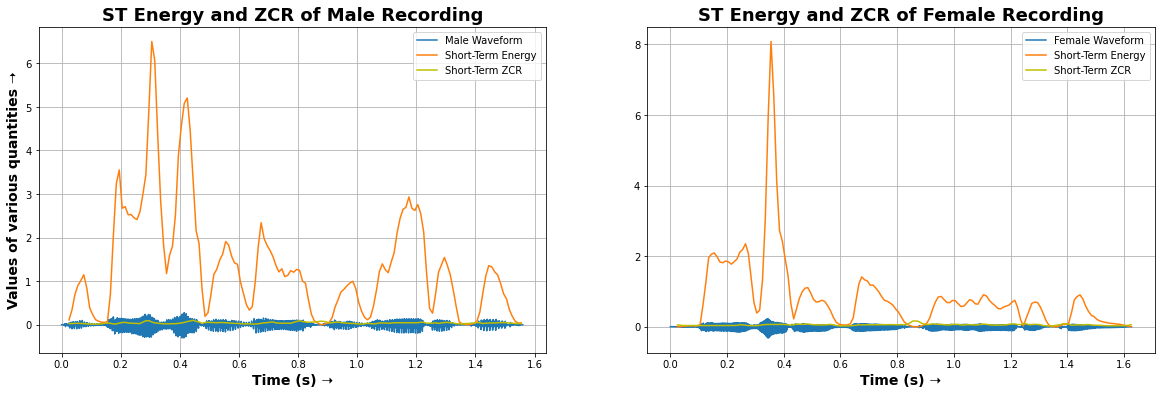

In [56]:
# Performing VAD for both recordings similar to Question 3

# Calculating ST energies and ZCR for male recording

window_ends_male = []
st_energies_male, st_zcrs_male = [], []

for i in range(window_size, len(data_male), shift_size):
    piece = data_male[(i-window_size):i]
    window_ends_male.append(i/samplerate_male)
    energy = np.sum(piece**2)
    zcr = (np.sum(piece[:-1]*piece[1:] < 0) + np.sum(piece[:-1]*piece[1:] == 0)/2)/window_size
    st_energies_male.append(energy)
    st_zcrs_male.append(zcr)

window_ends_male = np.array(window_ends_male)

#######################

# Calculating ST energies and ZCR for female recording

window_ends_female = []
st_energies_female, st_zcrs_female = [], []

for i in range(window_size, len(data_female), shift_size):
    piece = data_female[(i-window_size):i]
    window_ends_female.append(i/samplerate_female)
    energy = np.sum(piece**2)
    zcr = (np.sum(piece[:-1]*piece[1:] < 0) + np.sum(piece[:-1]*piece[1:] == 0)/2)/window_size
    st_energies_female.append(energy)
    st_zcrs_female.append(zcr)

window_ends_female = np.array(window_ends_female)

#######################

# Plotting these curves over the waveform

fig, ax = plt.subplots(1, 2, figsize=(20,6))
ax[0].plot(data_male_x_axis, data_male, label = 'Male Waveform')
ax[0].plot(window_ends_male, st_energies_male, label = "Short-Term Energy")
ax[0].plot(window_ends_male, st_zcrs_male, 'y', label = "Short-Term ZCR")
ax[0].legend()
ax[0].grid(True)
ax[0].set_title("ST Energy and ZCR of Male Recording", fontweight = 'bold', fontsize = 18)
ax[0].set_xlabel("Time (s) \u279d", fontweight = 'bold', fontsize = 14)
ax[0].set_ylabel("Values of various quantities \u279d", fontweight = 'bold', fontsize = 14)

ax[1].plot(data_female_x_axis, data_female, label = 'Female Waveform')
ax[1].plot(window_ends_female, st_energies_female, label = "Short-Term Energy")
ax[1].plot(window_ends_female, st_zcrs_female, 'y', label = "Short-Term ZCR")
ax[1].legend()
ax[1].grid(True)
ax[1].set_title("ST Energy and ZCR of Female Recording", fontweight = 'bold', fontsize = 18)
ax[1].set_xlabel("Time (s) \u279d", fontweight = 'bold', fontsize = 14)

plt.show()

In [58]:
# Calculating VAD thresholds similar to Question 3 for male recording

silence_energies_male = st_energies_male[-2:]
silence_zcrs_male =  st_zcrs_male[-2:]

zcr_thres_male = min(25/160, np.mean(st_zcrs_male) + 2*np.std(st_zcrs_male))
imx_male = max(st_energies_male)
imn_male = np.mean(silence_energies_male)
i1_male = 0.03*(imx_male-imn_male) + imn_male
i2_male = 4*imn_male
e_thres_male = min(i1_male, i2_male)

#########################

# Calculating VAD thresholds similarly for female recording

silence_energies_female = st_energies_female[:5]
silence_zcrs_female =  st_zcrs_female[:5]

zcr_thres_female = min(25/160, np.mean(st_zcrs_female) + 2*np.std(st_zcrs_female))
imx_female = max(st_energies_female)
imn_female = np.mean(silence_energies_female)
i1_female = 0.03*(imx_female-imn_female) + imn_female
i2_female = 4*imn_female
e_thres_female = min(i1_female, i2_female)

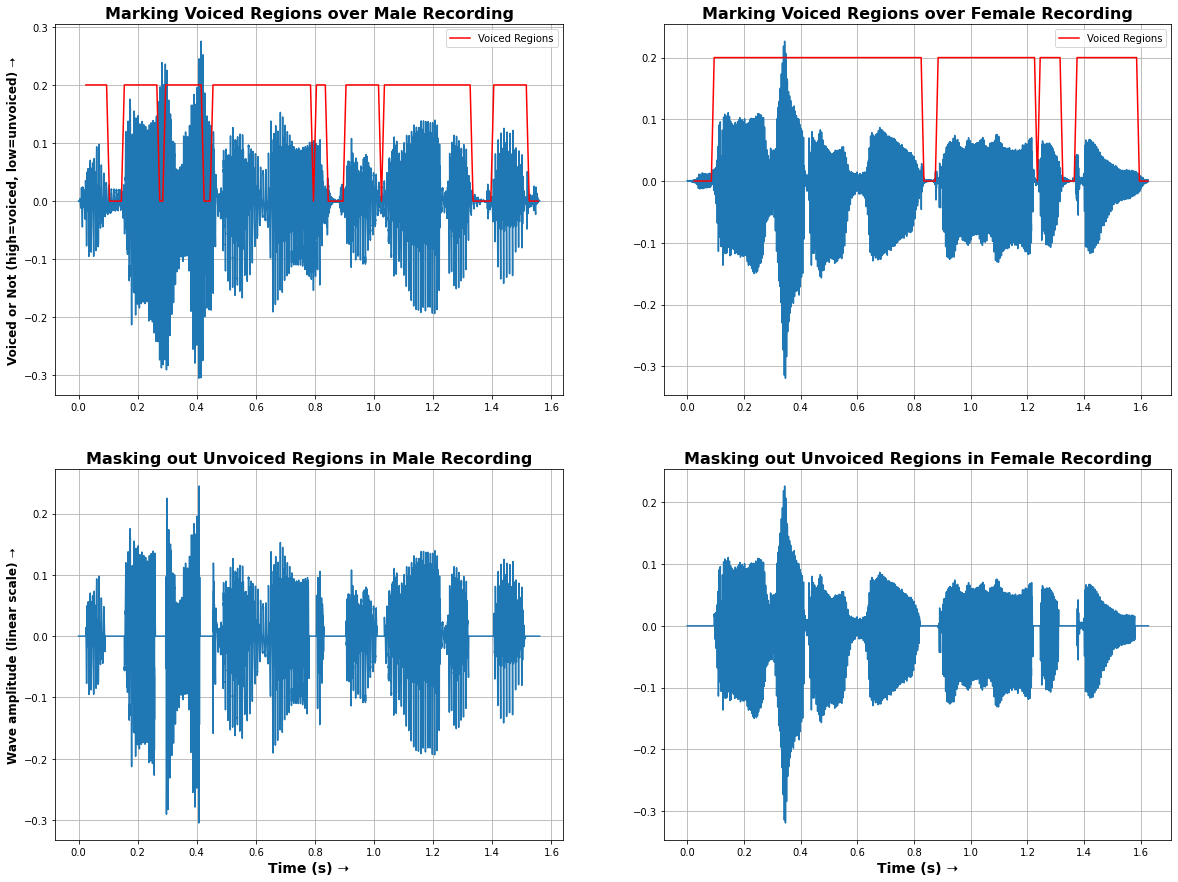

In [70]:
# Marking voiced regions and obtaining masked waveform after masking out unvoiced regions
# For male recording

fig, ax = plt.subplots(2, 2, figsize=(20,15))

high_energy_male = np.array(st_energies_male) > e_thres_male
low_zcr_male = np.array(st_zcrs_male) < zcr_thres_male
voiced_male = (high_energy_male & low_zcr_male) * 0.2
plot_voiced_male = np.concatenate((voiced_male[1:], [0]))

ax[0,0].plot(data_male_x_axis, data_male)
ax[0,0].plot(window_ends_male, plot_voiced_male, color='red', label="Voiced Regions")
ax[0,0].grid(True)
ax[0,0].legend()

ax[0,0].set_title("Marking Voiced Regions over Male Recording", fontweight = 'bold', fontsize = 16)
ax[0,0].set_ylabel("Voiced or Not (high=voiced, low=unvoiced) \u279d", fontweight = 'bold', fontsize = 12)

unvoiced_window_ends_male = window_ends_male[voiced_male==0]
unvoiced_window_starts_male = unvoiced_window_ends_male - 0.025

unvoiced_spans_male = zip(unvoiced_window_starts_male, unvoiced_window_ends_male)

vad_mask_male = np.ones(len(data_male))

for span in unvoiced_spans_male:
    start_ind = int(span[0]*samplerate_male)
    end_ind = int(span[1]*samplerate_male)
    vad_mask_male[start_ind:end_ind] = 0 

vad_mask_male[-400:] = 0

voiced_data_male = data_male*vad_mask_male

ax[1,0].plot(data_male_x_axis, voiced_data_male)
ax[1,0].grid(True)
ax[1,0].set_xlabel("Time (s) \u279d", fontweight = 'bold', fontsize = 14)
ax[1,0].set_ylabel("Wave amplitude (linear scale) \u279d", fontweight = 'bold', fontsize = 12)
ax[1,0].set_title("Masking out Unvoiced Regions in Male Recording", fontweight = 'bold', fontsize = 16)

########################

# Similarly for female recording

high_energy_female = np.array(st_energies_female) > e_thres_female
low_zcr_female = np.array(st_zcrs_female) < zcr_thres_female
voiced_female = (high_energy_female & low_zcr_female) * 0.2
plot_voiced_female = np.concatenate((voiced_female[1:], [0]))

ax[0,1].plot(data_female_x_axis, data_female)
ax[0,1].plot(window_ends_female, plot_voiced_female, color='red', label="Voiced Regions")
ax[0,1].grid(True)
ax[0,1].legend()
ax[0,1].set_title("Marking Voiced Regions over Female Recording", fontweight = 'bold', fontsize = 16)


unvoiced_window_ends_female = window_ends_female[voiced_female==0]
unvoiced_window_starts_female = unvoiced_window_ends_female - 0.025

unvoiced_spans_female = zip(unvoiced_window_starts_female, unvoiced_window_ends_female)

vad_mask_female = np.ones(len(data_female))

for span in unvoiced_spans_female:
    start_ind = int(span[0]*samplerate_female)
    end_ind = int(span[1]*samplerate_female)
    vad_mask_female[start_ind:end_ind] = 0  

vad_mask_female[-400:] = 0

voiced_data_female = data_female*vad_mask_female

ax[1,1].plot(data_female_x_axis, voiced_data_female)
ax[1,1].grid(True)
ax[1,1].set_xlabel("Time (s) \u279d", fontweight = 'bold', fontsize = 14)
ax[1,1].set_title("Masking out Unvoiced Regions in Female Recording", fontweight = 'bold', fontsize = 16)

plt.show()

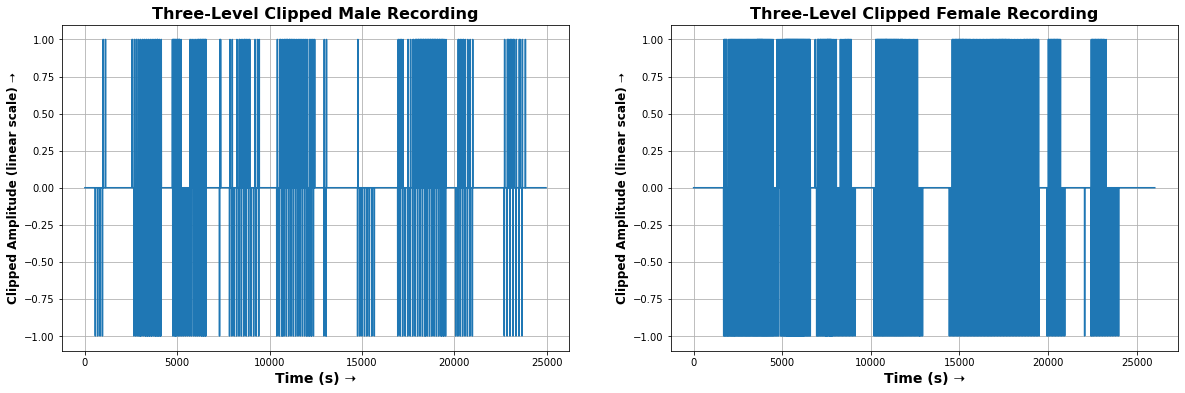

In [71]:
# Obtaining 3-level clipped male waveform

fig, axes = plt.subplots(1, 2, figsize=(20,6))

max_1st_third_male = max(voiced_data_male[:int(len(voiced_data_male)/3)])
max_last_third_male = max(voiced_data_male[int(2*len(voiced_data_male)/3):])
clip_thres_male = 0.6*min(max_1st_third_male, max_last_third_male)

positive_level_male = voiced_data_male > clip_thres_male
negative_level_male = voiced_data_male < -clip_thres_male
three_lev_data_male = positive_level_male.astype(int) - negative_level_male.astype(int)

axes[0].plot(three_lev_data_male)
axes[0].set_xlabel("Time (s) \u279d", fontweight = 'bold', fontsize = 14)
axes[0].set_ylabel("Clipped Amplitude (linear scale) \u279d", fontweight = 'bold', fontsize = 12)
axes[0].set_title("Three-Level Clipped Male Recording", fontweight = 'bold', fontsize = 16)
axes[0].grid(True)

##############################

# Obtaining 3-level clipped female waveform

max_1st_third_female = max(voiced_data_female[:int(len(voiced_data_female)/3)])
max_last_third_female = max(voiced_data_female[int(2*len(voiced_data_female)/3):])
clip_thres_female = 0.6*min(max_1st_third_female, max_last_third_female)

positive_level_female = voiced_data_female > clip_thres_female
negative_level_female = voiced_data_female < -clip_thres_female
three_lev_data_female = positive_level_female.astype(int) - negative_level_female.astype(int)

axes[1].plot(three_lev_data_female)
axes[1].set_xlabel("Time (s) \u279d", fontweight = 'bold', fontsize = 14)
axes[1].set_ylabel("Clipped Amplitude (linear scale) \u279d", fontweight = 'bold', fontsize = 12)
axes[1].set_title("Three-Level Clipped Female Recording", fontweight = 'bold', fontsize = 16)
axes[1].grid(True)

plt.show()

In [73]:
# Calculating pitch contours for male recording as in Question 4

pitch_period_samples_male, pitch_period_samples_female = [], []

for i in range(0, len(three_lev_data_male)-window_size+1, shift_size):
    three_lev_piece = three_lev_data_male[i:i+window_size]
    auto_corr = [autocorrelation(three_lev_piece, k) for k in range(len(three_lev_piece))]
    if(max(auto_corr) > 0):
        auto_corr = auto_corr/max(auto_corr)

    local_maximum = float('nan')
    peaks, _ = find_peaks(auto_corr, prominence=0.6)
    if len(peaks) > 0:
        local_maximum = peaks[0]
    if np.count_nonzero(vad_mask[i:i+window_size]) < window_size:
        local_maximum = float('nan')

    pitch_period_samples_male.append(local_maximum)

extracted_pitches_male = np.array([samplerate_male/pitch_period if pitch_period != float('nan') else float ('nan') 
                              for pitch_period in pitch_period_samples_male])

###########################

# Similarly calculating pitch contours for female recording as in Question 4

for i in range(0, len(three_lev_data_female)-window_size+1, shift_size):
    three_lev_piece = three_lev_data_female[i:i+window_size]
    auto_corr = [autocorrelation(three_lev_piece, k) for k in range(len(three_lev_piece))]
    if(max(auto_corr) > 0):
        auto_corr = auto_corr/max(auto_corr)

    local_maximum = float('nan')
    peaks, _ = find_peaks(auto_corr, prominence=0.9)
    if len(peaks) > 0:
        local_maximum = peaks[0]
    if np.count_nonzero(vad_mask[i:i+window_size]) < window_size:
        local_maximum = float('nan')

    pitch_period_samples_female.append(local_maximum)


extracted_pitches_female = np.array([samplerate_female/pitch_period if pitch_period != float('nan') else float ('nan') 
                              for pitch_period in pitch_period_samples_female])

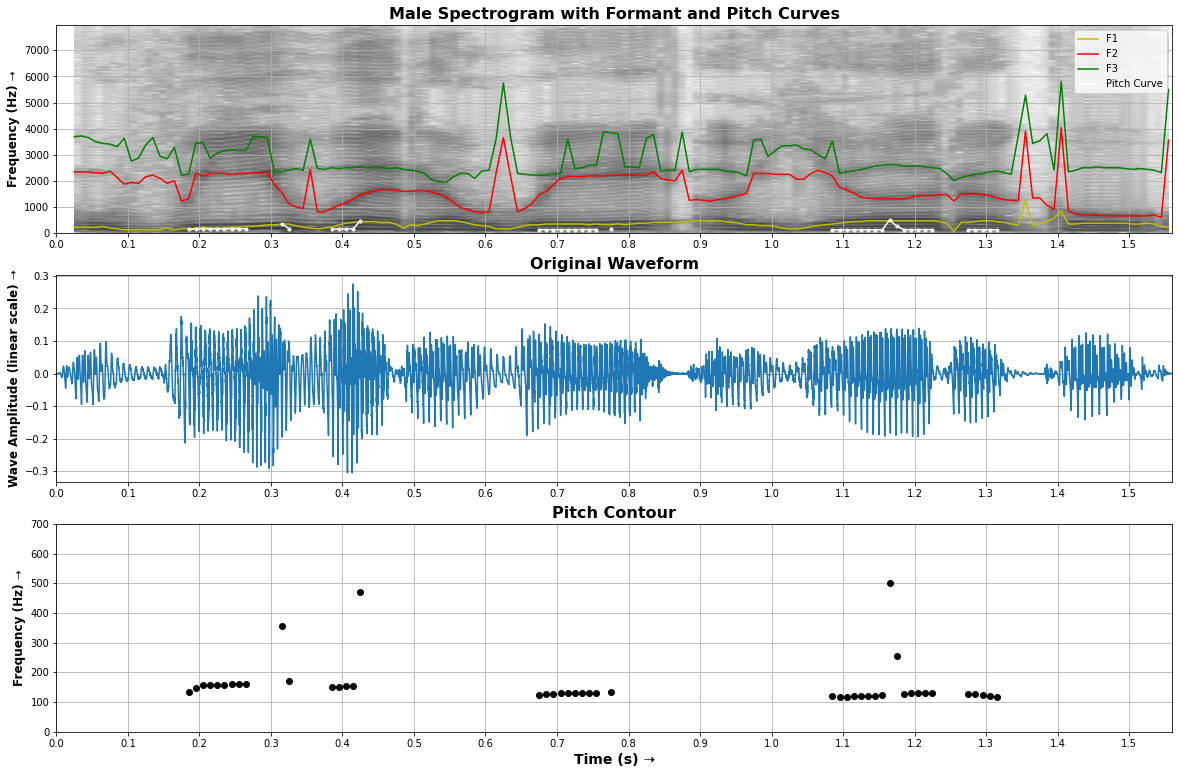

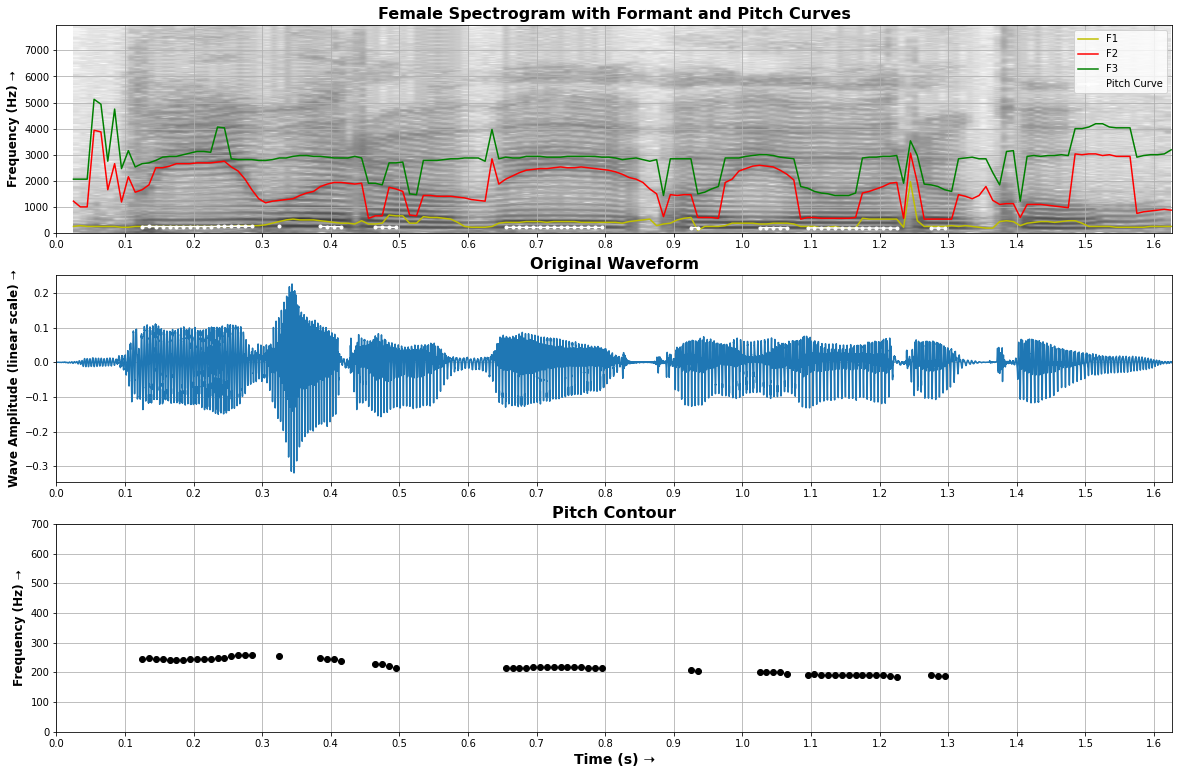

In [82]:
# Plotting spectrogram and overlaying pitch and formant curves alongside original waveform
# Also plotting pitch contours separately to better observe difference in male and female pitch frequency
# FOR BOTH WAVEFORMS

x_axis_male = (window_size/samplerate_male) + np.arange(len(f1_male))*shift_size/samplerate_male

positive_freq_axis_male = freq_axis_male[:int(len(freq_axis_male)/2)]

fig_male, ax_male = plt.subplots(3,1,figsize=(20,13))
ax_male[0].imshow(spectrogram_male, cmap = 'Greys', alpha = 0.8, aspect = 'auto', 
                  origin = 'lower', extent=[x_axis_male[0],x_axis_male[-1],0, positive_freq_axis_male[-1]])
ax_male[0].plot(x_axis_male, f1_male, 'y', label = "F1")
ax_male[0].plot(x_axis_male, f2_male, 'r', label = "F2")
ax_male[0].plot(x_axis_male, f3_male, 'g', label = "F3")
ax_male[0].grid(True)
ax_male[0].set_xlim(0, len(data_male)/samplerate_male)
ax_male[0].set_xticks(np.arange(0,1.6,0.1))
ax_male[0].plot(x_axis_male, extracted_pitches_male, 'o-', color='white', markersize = 3, label = "Pitch Curve")
ax_male[0].set_ylabel("Frequency (Hz) \u279d", fontweight = 'bold', fontsize = 12)
ax_male[0].set_title("Male Spectrogram with Formant and Pitch Curves", fontweight = 'bold', fontsize = 16)
ax_male[0].legend()


ax_male[1].plot(np.arange(len(data_male))/samplerate_male, data_male)
ax_male[1].grid(True)
ax_male[1].set_xlim(0, len(data_male)/samplerate_male)
ax_male[1].set_xticks(np.arange(0,1.6,0.1))
ax_male[1].set_ylabel("Wave Amplitude (linear scale) \u279d", fontweight = 'bold', fontsize = 12)
ax_male[1].set_title("Original Waveform", fontweight = 'bold', fontsize = 16)

ax_male[2].plot(x_axis_male, extracted_pitches_male, 'o', color='black')
ax_male[2].set_xlim(0, len(data_male)/samplerate_male)
ax_male[2].set_ylim(0,700)
ax_male[2].set_xticks(np.arange(0,1.6,0.1))
ax_male[2].grid(True)
ax_male[2].set_xlabel("Time (s) \u279d", fontweight = 'bold', fontsize = 14)
ax_male[2].set_ylabel("Frequency (Hz) \u279d", fontweight = 'bold', fontsize = 12)
ax_male[2].set_title("Pitch Contour", fontweight = 'bold', fontsize = 16)

plt.show()

#########################

x_axis_female = (window_size/samplerate_female) + np.arange(len(f1_female))*shift_size/samplerate_female

positive_freq_axis_female = freq_axis_female[:int(len(freq_axis_female)/2)]

fig_female, ax_female = plt.subplots(3,1,figsize=(20,13))
ax_female[0].imshow(spectrogram_female, cmap = 'Greys', alpha = 0.8, aspect = 'auto', 
                    origin = 'lower', extent=[x_axis_female[0],x_axis_female[-1],0, positive_freq_axis_female[-1]])
ax_female[0].plot(x_axis_female, f1_female, 'y', label = "F1")
ax_female[0].plot(x_axis_female, f2_female, 'r', label = "F2")
ax_female[0].plot(x_axis_female, f3_female, 'g', label = "F3")
ax_female[0].grid(True)
ax_female[0].set_xlim(0, len(data_female)/samplerate_female)
ax_female[0].set_xticks(np.arange(0,1.7,0.1))
ax_female[0].plot(x_axis_female, extracted_pitches_female, 'o-', color='white', markersize = 3, label = "Pitch Curve")
ax_female[0].set_ylabel("Frequency (Hz) \u279d", fontweight = 'bold', fontsize = 12)
ax_female[0].set_title("Female Spectrogram with Formant and Pitch Curves", fontweight = 'bold', fontsize = 16)
ax_female[0].legend()

ax_female[1].plot(np.arange(len(data_female))/samplerate_female, data_female)
ax_female[1].grid(True)
ax_female[1].set_xlim(0, len(data_female)/samplerate_female)
ax_female[1].set_xticks(np.arange(0,1.7,0.1))
ax_female[1].set_ylabel("Wave Amplitude (linear scale) \u279d", fontweight = 'bold', fontsize = 12)
ax_female[1].set_title("Original Waveform", fontweight = 'bold', fontsize = 16)

ax_female[2].plot(x_axis_female, extracted_pitches_female, 'o', color='black')
ax_female[2].set_xlim(0, len(data_female)/samplerate_female)
ax_female[2].set_ylim(0,700)
ax_female[2].set_xticks(np.arange(0,1.7,0.1))
ax_female[2].grid(True)
ax_female[2].set_xlabel("Time (s) \u279d", fontweight = 'bold', fontsize = 14)
ax_female[2].set_ylabel("Frequency (Hz) \u279d", fontweight = 'bold', fontsize = 12)
ax_female[2].set_title("Pitch Contour", fontweight = 'bold', fontsize = 16)

plt.show()  

______________________________________________